In [1]:
import os
import pandas as pd
import numpy as np
import time

In [2]:
df=pd.read_csv(r'data/AURN_data_download/Westminster/MY1.csv',parse_dates=['date'],index_col='date')

In [3]:
era=pd.read_csv(r'data/era5_data/MY1_era.csv',parse_dates=['date'],index_col='date')

In [4]:
df1=pd.concat([df,era],axis=1)

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
from random import sample
from scipy import stats
from flaml import AutoML
from joblib import Parallel, delayed
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [126]:
import pandas as pd
import numpy as np
from datetime import datetime
from random import sample
from scipy import stats
from flaml import AutoML
from joblib import Parallel, delayed
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

def emi_decom(df, value, feature_names, split_method='random', time_budget=60, metric='r2',
             estimator_list=["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"], task='regression',
             n_samples=300, fraction=0.75, seed=7654321, n_cores=-1):
    """
    Decomposes a time series into different components using machine learning models.

    This function prepares the data, trains a machine learning model using AutoML, and decomposes
    the time series data into various components. The decomposition is based on the contribution
    of different features to the target variable. It returns the decomposed data and model statistics.

    Parameters:
        df (pd.DataFrame): Input dataframe containing the time series data.
        value (str): Column name of the target variable.
        feature_names (list of str): List of feature column names.
        split_method (str, optional): Method to split the data ('random' or other methods). Default is 'random'.
        time_budget (int, optional): Time budget for the AutoML training in seconds. Default is 60.
        metric (str, optional): Metric to evaluate the model ('r2', 'mae', etc.). Default is 'r2'.
        estimator_list (list of str, optional): List of estimators to be used in AutoML. Default is ["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"].
        task (str, optional): Task type ('regression' or 'classification'). Default is 'regression'.
        n_samples (int, optional): Number of samples for normalization. Default is 300.
        fraction (float, optional): Fraction of data to be used for training. Default is 0.75.
        seed (int, optional): Random seed for reproducibility. Default is 7654321.
        n_cores (int, optional): Number of cores to be used (-1 for all available cores). Default is -1.

    Returns:
        df_dewc (pd.DataFrame): Dataframe with decomposed components.
        mod_stats (pd.DataFrame): Dataframe with model statistics.

    Example:
        >>> df = pd.read_csv('timeseries_data.csv')
        >>> value = 'target'
        >>> feature_names = ['feature1', 'feature2', 'feature3']
        >>> df_dewc, mod_stats = ts_decom(df, value, feature_names)
    """

    # Prepare the data for modeling
    df = prepare_data(df, value=value, feature_names=feature_names, split_method=split_method, fraction=fraction, seed=seed)

    # Train the model using AutoML
    automl = train_model(df, value='value', variables=feature_names, time_budget=time_budget, metric=metric, task=task, seed=seed)

    # Gather model statistics for testing, training, and all data
    mod_stats = pd.concat([modStats(df, automl, set='testing'),
                           modStats(df, automl, set='training'),
                           modStats(df.assign(set="all"), automl, set='all')])

    # Initialize the dataframe for decomposed components
    var_names = feature_names
    df_dew = df[['date', 'value']].set_index('date').rename(columns={'value': 'Observed'})

    # Decompose the time series by excluding different features
    for var_to_exclude in ['base', 'date_unix', 'day_julian', 'weekday', 'hour']:
        var_names = list(set(var_names) - set([var_to_exclude]))
        df_dew_temp = normalise(automl, df, feature_names=feature_names, variables=var_names,
                                n_samples=n_samples, n_cores=n_cores, seed=seed)

        df_dew[var_to_exclude] = df_dew_temp['Normalised']

    # Adjust the decomposed components to create deweathered values
    df_dewc = df_dew.copy()
    df_dewc['hour'] = df_dew['hour'] - df_dew['weekday']
    df_dewc['weekday'] = df_dew['weekday'] - df_dew['day_julian']
    df_dewc['day_julian'] = df_dew['day_julian'] - df_dew['date_unix']
    df_dewc['date_unix'] = df_dew['date_unix'] - df_dew['base'] + df_dew['base'].mean()
    df_dewc['emi_noise'] =  df_dew['base']- df_dew['base'].mean()
    df_dewc['Deweathered'] = df_dew['hour']

    return df_dewc, mod_stats


def met_rolling(df, value, feature_names, split_method='random', time_budget=60, metric='r2',
                estimator_list=["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"], task='regression',
                n_samples=300, window_days=14, rollingevery=2, fraction=0.75, seed=7654321, n_cores=-1):
    """
    Applies a rolling window approach to decompose the time series into different components using machine learning models.

    This function prepares the data, trains a machine learning model using AutoML, and applies a rolling window approach
    to decompose the time series data into various components. The decomposition is based on the contribution of different
    features to the target variable. It returns the decomposed data and model statistics.

    Parameters:
        df (pd.DataFrame): Input dataframe containing the time series data.
        value (str): Column name of the target variable.
        feature_names (list of str): List of feature column names.
        split_method (str, optional): Method to split the data ('random' or other methods). Default is 'random'.
        time_budget (int, optional): Time budget for the AutoML training in seconds. Default is 60.
        metric (str, optional): Metric to evaluate the model ('r2', 'mae', etc.). Default is 'r2'.
        estimator_list (list of str, optional): List of estimators to be used in AutoML. Default is ["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"].
        task (str, optional): Task type ('regression' or 'classification'). Default is 'regression'.
        n_samples (int, optional): Number of samples for normalization. Default is 300.
        window_days (int, optional): Number of days for the rolling window. Default is 14.
        rollingevery (int, optional): Rolling interval in days. Default is 2.
        fraction (float, optional): Fraction of data to be used for training. Default is 0.75.
        seed (int, optional): Random seed for reproducibility. Default is 7654321.
        n_cores (int, optional): Number of cores to be used (-1 for all available cores). Default is -1.

    Returns:
        df_dew (pd.DataFrame): Dataframe with decomposed components including mean and standard deviation of the rolling window.
        mod_stats (pd.DataFrame): Dataframe with model statistics.

    Example:
        >>> df = pd.read_csv('timeseries_data.csv')
        >>> value = 'target'
        >>> feature_names = ['feature1', 'feature2', 'feature3']
        >>> df_dew, mod_stats = met_rolling(df, value, feature_names, window_days=14, rollingevery=2)
    """

    # Prepare the data for modeling
    df = prepare_data(df, value=value, feature_names=feature_names, split_method=split_method, fraction=fraction, seed=seed)

    # Train the model using AutoML
    automl = train_model(df, value='value', variables=feature_names, time_budget=time_budget, metric=metric, task=task, seed=seed)

    # Gather model statistics for testing, training, and all data
    mod_stats = pd.concat([
        modStats(df, automl, set='testing'),
        modStats(df, automl, set='training'),
        modStats(df.assign(set="all"), automl, set='all')
    ])

    # Variables to be used in resampling
    variables_resample = [item for item in feature_names if item not in ['hour', 'weekday', 'day_julian', 'date_unix']]

    # Normalize the data
    df_dew = normalise(automl, df, feature_names=feature_names, variables=variables_resample, n_samples=n_samples, n_cores=n_cores, seed=seed)

    # Initialize the dataframe for rolling window results
    dfr = pd.DataFrame(index=df_dew.index)
    df['date_d'] = pd.to_datetime(df['date']).dt.date
    date_max = pd.to_datetime(df['date_d'].max() - pd.DateOffset(days=window_days - 1))
    date_min = pd.to_datetime(df['date_d'].min() + pd.DateOffset(days=window_days - 1))

    # Apply the rolling window approach
    for i, ds in enumerate(pd.to_datetime(df['date_d'][df['date_d'] <= date_max.date()]).unique()[::rollingevery]):
        dfa = df[df['date_d'] >= ds.date()]
        dfa = dfa[dfa['date_d'] <= (dfa['date_d'].min() + pd.DateOffset(days=window_days)).date()]
        dfar = normalise(automl=automl, df=dfa, feature_names=feature_names, variables=variables_resample, n_samples=n_samples, n_cores=n_cores, seed=seed)
        dfar.rename(columns={'Normalised':'Rolling_'+str(i)},inplace=True)

        # Concatenate the results
        dfr = pd.concat([dfr, dfar['Rolling_'+str(i)]], axis=1)

    # Calculate the mean and standard deviation for the rolling window
    df_dew['EMI_mean_' + str(window_days)] = np.mean(dfr.iloc[:, 1:], axis=1)
    df_dew['EMI_std_' + str(window_days)] = np.std(dfr.iloc[:, 1:], axis=1)

    # Calculate the short-term and seasonal components
    df_dew['MET_short'] = df_dew['Observed'] - df_dew['EMI_mean_' + str(window_days)]
    df_dew['MET_season'] = df_dew['EMI_mean_' + str(window_days)] - df_dew['Normalised']

    return df_dew, mod_stats

def met_decom(df, value, feature_names, split_method='random', time_budget=60, metric='r2',
              estimator_list=["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"], task='regression',
              n_samples=300, fraction=0.75, seed=7654321, importance_ascending=False, n_cores=-1):
    """
    Decomposes a time series into different components using machine learning models with feature importance ranking.

    This function prepares the data, trains a machine learning model using AutoML, and decomposes the time series data
    into various components. The decomposition is based on the feature importance ranking and their contributions to the
    target variable. It returns the decomposed data and model statistics.

    Parameters:
        df (pd.DataFrame): Input dataframe containing the time series data.
        value (str): Column name of the target variable.
        feature_names (list of str): List of feature column names.
        split_method (str, optional): Method to split the data ('random' or other methods). Default is 'random'.
        time_budget (int, optional): Time budget for the AutoML training in seconds. Default is 60.
        metric (str, optional): Metric to evaluate the model ('r2', 'mae', etc.). Default is 'r2'.
        estimator_list (list of str, optional): List of estimators to be used in AutoML. Default is ["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"].
        task (str, optional): Task type ('regression' or 'classification'). Default is 'regression'.
        n_samples (int, optional): Number of samples for normalization. Default is 300.
        fraction (float, optional): Fraction of data to be used for training. Default is 0.75.
        seed (int, optional): Random seed for reproducibility. Default is 7654321.
        importance_ascending (bool, optional): Sort order for feature importances. Default is False.
        n_cores (int, optional): Number of cores to be used (-1 for all available cores). Default is -1.

    Returns:
        df_dewwc (pd.DataFrame): Dataframe with decomposed components.
        mod_stats (pd.DataFrame): Dataframe with model statistics.

    Example:
        >>> df = pd.read_csv('timeseries_data.csv')
        >>> value = 'target'
        >>> feature_names = ['feature1', 'feature2', 'feature3']
        >>> df_dewwc, mod_stats = met_decom(df, value, feature_names)
    """

    # Prepare the data for modeling
    df = prepare_data(df, value=value, feature_names=feature_names, split_method=split_method, fraction=fraction, seed=seed)

    # Train the model using AutoML
    automl = train_model(df, value='value', variables=feature_names, time_budget=time_budget, metric=metric, task=task, seed=seed)

    # Gather model statistics for testing, training, and all data
    mod_stats = pd.concat([
        modStats(df, automl, set='testing'),
        modStats(df, automl, set='training'),
        modStats(df.assign(set="all"), automl, set='all')
    ])

    # Determine feature importances and sort them

    automlfi = pd.DataFrame(data={'feature_importances': automl.feature_importances_},
                            index=automl.feature_names_in_).sort_values('feature_importances', ascending=importance_ascending)

    # Initialize the dataframe for decomposed components
    df_deww = df[['date', 'value']].set_index('date').rename(columns={'value': 'Observed'})
    MET_list = ['Deweathered'] + [item for item in automlfi.index if item not in ['hour', 'weekday', 'day_julian', 'date_unix']]
    var_names = [item for item in automlfi.index if item not in ['hour', 'weekday', 'day_julian', 'date_unix']]

    # Decompose the time series by excluding different features based on their importance
    for var_to_exclude in MET_list:
        var_names = list(set(var_names) - set([var_to_exclude]))
        df_dew_temp = normalise(automl, df, feature_names=feature_names, variables=var_names, n_samples=n_samples, n_cores=n_cores, seed=seed)
        df_deww[var_to_exclude] = df_dew_temp['Normalised']

    # Adjust the decomposed components to create weather-independent values
    df_dewwc = df_deww.copy()
    for i, param in enumerate([item for item in automlfi.index if item not in ['hour', 'weekday', 'day_julian', 'date_unix']]):
        if i > 0:
            df_dewwc[param] = df_deww[param] - df_deww[MET_list[i - 1]]
        else:
            df_dewwc[param] = df_deww[param] - df_deww['Deweathered']

    df_dewwc['met_noise'] = df_deww['Observed'] - df_deww[MET_list[-1]]

    return df_dewwc, mod_stats


def rolling_dew(df, value, feature_names, variables_resample, split_method='random', time_budget=60, metric='r2',
                estimator_list=["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"], task='regression',
                n_samples=300, window_days=14, rollingevery=2, fraction=0.75, seed=7654321, n_cores=-1):
    """
    Applies a rolling window approach to decompose the time series into different components using machine learning models.

    This function prepares the data, trains a machine learning model using AutoML, and applies a rolling window approach
    to decompose the time series data into various components. The decomposition is based on the contribution of different
    features to the target variable over rolling windows. It returns the decomposed data and model statistics.

    Parameters:
        df (pd.DataFrame): Input dataframe containing the time series data.
        value (str): Column name of the target variable.
        feature_names (list of str): List of feature column names.
        split_method (str, optional): Method to split the data ('random' or other methods). Default is 'random'.
        time_budget (int, optional): Time budget for the AutoML training in seconds. Default is 60.
        metric (str, optional): Metric to evaluate the model ('r2', 'mae', etc.). Default is 'r2'.
        estimator_list (list of str, optional): List of estimators to be used in AutoML. Default is ["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"].
        task (str, optional): Task type ('regression' or 'classification'). Default is 'regression'.
        variables_resample (list of str): List of sampled feature names for normalization.
        n_samples (int, optional): Number of samples for normalization. Default is 300.
        window_days (int, optional): Number of days for the rolling window. Default is 14.
        rollingevery (int, optional): Rolling interval in days. Default is 2.
        fraction (float, optional): Fraction of data to be used for training. Default is 0.75.
        seed (int, optional): Random seed for reproducibility. Default is 7654321.
        n_cores (int, optional): Number of cores to be used (-1 for all available cores). Default is -1.

    Returns:
        dfr (pd.DataFrame): Dataframe with rolling decomposed components.
        mod_stats (pd.DataFrame): Dataframe with model statistics.

    Example:
        >>> df = pd.read_csv('timeseries_data.csv')
        >>> value = 'target'
        >>> feature_names = ['feature1', 'feature2', 'feature3']
        >>> variables_resample = ['feature1', 'feature2']
        >>> dfr, mod_stats = rolling_dew(df, value, feature_names, variables_resample)
    """

    # Prepare the data
    df = prepare_data(df, value=value, feature_names=feature_names, split_method=split_method, fraction=fraction, seed=seed)

    # Train the model using AutoML
    automl = train_model(df, value='value', variables=feature_names, time_budget=time_budget, metric=metric, task=task, seed=seed)

    # Collect model statistics
    mod_stats = pd.concat([
        modStats(df, automl, set='testing'),
        modStats(df, automl, set='training'),
        modStats(df.assign(set="all"), automl, set='all')
    ])

    # Create an initial dataframe to store observed values
    dfr = pd.DataFrame(index=df['date'], data={'Observed': list(df['value'])})
    df['date_d'] = df['date'].dt.date

    # Define the rolling window range
    date_max = df['date_d'].max() - pd.DateOffset(days=window_days - 1)
    date_min = df['date_d'].min() + pd.DateOffset(days=window_days - 1)

    # Iterate over the rolling windows
    for i, ds in enumerate(pd.to_datetime(df['date_d'][df['date_d'] <= date_max.date()]).unique()[::rollingevery]):
        dfa = df[df['date_d'] >= ds.date()]
        dfa = dfa[dfa['date_d'] <= (dfa['date_d'].min() + pd.DateOffset(days=window_days)).date()]

        # Normalize the data within the rolling window
        dfar = normalise(automl=automl, df=dfa, feature_names=feature_names, variables=variables_resample,
                         n_samples=n_samples, n_cores=n_cores, seed=seed)
        dfar.rename(columns={'Normalised':'Rolling_'+str(i)},inplace=True)

        # Concatenate the results
        dfr = pd.concat([dfr, dfar['Rolling_'+str(i)]], axis=1)

    return dfr, mod_stats

def do_all(df, value, feature_names, variables_resample, split_method='random', time_budget=60, metric='r2',
           estimator_list=["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"], task='regression',
           n_samples=300, fraction=0.75, seed=7654321, n_cores=-1):
    """
    Conducts data preparation, model training, and normalization, returning the transformed dataset and model statistics.

    This function performs the entire pipeline from data preparation to model training and normalization using
    specified parameters and returns the transformed dataset along with model statistics.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing the dataset.
        value (str): Name of the target variable.
        feature_names (list of str): List of feature names.
        variables_resample (list of str): List of variables for normalization.
        split_method (str, optional): Method for splitting data ('random' or 'time_series'). Default is 'random'.
        time_budget (int, optional): Maximum time allowed for training models, in seconds. Default is 60.
        metric (str, optional): Evaluation metric for model performance ('r2', 'mae', etc.). Default is 'r2'.
        estimator_list (list of str, optional): List of estimator names to be used in training. Default is ["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"].
        task (str, optional): Task type ('regression' or 'classification'). Default is 'regression'.
        n_samples (int, optional): Number of samples for normalization. Default is 300.
        fraction (float, optional): Fraction of the dataset to be used for training. Default is 0.75.
        seed (int, optional): Seed for random operations. Default is 7654321.
        n_cores (int, optional): Number of CPU cores to be used for normalization (-1 for all available cores). Default is -1.

    Returns:
        tuple:
            - df_dew (pd.DataFrame): Transformed dataset with normalized values.
            - mod_stats (pd.DataFrame): DataFrame containing model statistics.

    Example:
        >>> df = pd.read_csv('timeseries_data.csv')
        >>> value = 'target'
        >>> feature_names = ['feature1', 'feature2', 'feature3']
        >>> variables_resample = ['feature1', 'feature2']
        >>> df_dew, mod_stats = do_all(df, value, feature_names, variables_resample)
    """

    # Prepare the data
    df = prepare_data(df, value=value, feature_names=feature_names, split_method=split_method, fraction=fraction, seed=seed)

    # Train the model using AutoML
    automl = train_model(df, value='value', variables=feature_names, time_budget=time_budget, metric=metric, task=task, seed=seed)

    # Collect model statistics
    mod_stats = pd.concat([
        modStats(df, automl, set='testing'),
        modStats(df, automl, set='training'),
        modStats(df.assign(set="all"), automl, set='all')
    ])

    # Normalize the data
    df_dew = normalise(automl, df, feature_names=feature_names, variables=variables_resample, n_samples=n_samples,aggregate=True, n_cores=n_cores, seed=seed)

    return df_dew, mod_stats

def do_all_unc(df, value, feature_names, variables_resample, split_method='random', time_budget=60, metric='r2',
               estimator_list=["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"], task='regression',
               n_models=10, confidence_level=0.95, n_samples=300, fraction=0.75, seed=7654321, n_cores=-1):
    """
    Performs uncertainty quantification by training multiple models with different random seeds and calculates statistical metrics.

    This function performs the entire pipeline from data preparation to model training and normalization, with an added step
    to quantify uncertainty by training multiple models using different random seeds. It returns a dataframe containing observed
    values, mean, standard deviation, median, confidence bounds, and weighted values, as well as a dataframe with model statistics.

    Parameters:
        df (pd.DataFrame): Input dataframe containing the time series data.
        value (str): Column name of the target variable.
        feature_names (list of str): List of feature column names.
        split_method (str, optional): Method to split the data ('random' or other methods). Default is 'random'.
        time_budget (int, optional): Time budget for the AutoML training. Default is 60.
        metric (str, optional): Metric to evaluate the model ('r2', 'mae', etc.). Default is 'r2'.
        estimator_list (list of str, optional): List of estimators to be used in AutoML. Default is ["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"].
        task (str, optional): Task type ('regression' or 'classification'). Default is 'regression'.
        n_models (int, optional): Number of models to train for uncertainty quantification. Default is 10.
        confidence_level (float, optional): Confidence level for the uncertainty bounds. Default is 0.95.
        variables_resample (list of str): List of sampled feature names for normalization (optional).
        n_samples (int, optional): Number of samples for normalization. Default is 300.
        fraction (float, optional): Fraction of data to be used for training. Default is 0.75.
        seed (int, optional): Random seed for reproducibility. Default is 7654321.
        n_cores (int, optional): Number of cores to be used (-1 for all available cores). Default is -1.

    Returns:
        tuple:
            - df_dew (pd.DataFrame): Dataframe with observed values, mean, standard deviation, median, lower and upper bounds, and weighted values.
            - mod_stats (pd.DataFrame): Dataframe with model statistics.

    Example:
        >>> df = pd.read_csv('timeseries_data.csv')
        >>> value = 'target'
        >>> feature_names = ['feature1', 'feature2', 'feature3']
        >>> variables_resample = ['feature1', 'feature2']
        >>> df_dew, mod_stats = do_all_unc(df, value, feature_names, variables_resample)
    """

    np.random.seed(seed)
    random_seeds = np.random.choice(np.arange(1000001), size=n_models, replace=False)
    df_dew = None
    mod_stats = None

    for i in random_seeds:
        df_dew0, mod_stats0 = do_all(df=df, value=value,
                                     feature_names=feature_names,
                                     split_method=split_method, time_budget=time_budget,
                                     variables_resample=variables_resample,
                                     n_samples=n_samples, fraction=fraction, seed=i, n_cores=n_cores)
        df_dew0.rename(columns={'Normalised':'Normalised_'+str(i)},inplace=True)
        df_dew0=df_dew0[['Observed','Normalised_'+str(i)]]
        if df_dew is None:
            df_dew = df_dew0
        else:
            df_dew = pd.concat([df_dew, df_dew0.iloc[:,1]], axis=1)

        mod_stats0['seed'] = i
        if mod_stats is None:
            mod_stats = mod_stats0
        else:
            mod_stats = pd.concat([mod_stats, mod_stats0], ignore_index=True)

    df_dew['mean'] = df_dew.iloc[:, 1:n_models+1].mean(axis=1)
    df_dew['std'] = df_dew.iloc[:, 1:n_models+1].std(axis=1)
    df_dew['median'] = df_dew.iloc[:, 1:n_models+1].median(axis=1)
    df_dew['lower_bound'] = df_dew.iloc[:, 1:n_models+1].quantile((1 - confidence_level) / 2, axis=1)
    df_dew['upper_bound'] = df_dew.iloc[:, 1:n_models+1].quantile(1 - (1 - confidence_level) / 2, axis=1)

    test_stats = mod_stats[mod_stats['set'] == 'testing']
    test_stats['R2'] = test_stats['R2'].replace([np.inf, -np.inf], np.nan)
    normalized_R2 = (test_stats['R2'] - test_stats['R2'].min()) / (test_stats['R2'].max() - test_stats['R2'].min())
    weighted_R2 = normalized_R2 / normalized_R2.sum()

    df_dew1 = df_dew.copy()
    df_dew1.iloc[:, 1:n_models+1] = df_dew.iloc[:, 1:n_models+1].values * weighted_R2.values
    df_dew['weighted'] = df_dew1.iloc[:, 1:n_models+1].sum(axis=1)

    return df_dew, mod_stats


def prepare_data(df, value, feature_names, prepared=False, na_rm=True, split_method='random', replace=False, fraction=0.75, seed=7654321):
    """
    Prepares the input DataFrame by performing data cleaning, imputation, and splitting.

    Parameters:
        df (DataFrame): Input DataFrame containing the dataset.
        value (str, optional): Name of the target variable. Default is 'value'.
        feature_names (list, optional): List of feature names. Default is None.
        na_rm (bool, optional): Whether to remove missing values. Default is True.
        split_method (str, optional): Method for splitting data ('random' or 'time_series'). Default is 'random'.
        replace (bool, optional): Whether to replace existing date variables. Default is False.
        fraction (float, optional): Fraction of the dataset to be used for training. Default is 0.75.
        seed (int, optional): Seed for random operations. Default is 7654321.

    Returns:
        DataFrame: Prepared DataFrame with cleaned data and split into training and testing sets.
    """

    # Perform the data preparation steps
    df = (df
          .pipe(check_data, value=value,feature_names=feature_names)
          .pipe(impute_values, na_rm=na_rm)
          .pipe(add_date_variables, replace=replace)
          .pipe(split_into_sets, split_method=split_method, fraction=fraction, seed=seed)
          .reset_index(drop=True))

    return df

def check_data(df, value, feature_names):
    """
    Validates and preprocesses the input DataFrame for subsequent analysis or modeling.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame containing the data to be checked.
    value : str
        The name of the target variable (column) to be used in the analysis.
    feature_names : list of str
        A list of feature names to be included in the analysis. If empty, all columns are used.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing only the necessary columns, with appropriate checks and transformations applied.

    Raises:
    -------
    ValueError:
        If any of the following conditions are met:
        - The target variable (`value`) is not in the DataFrame columns.
        - There is no datetime information in either the index or the 'date' column.
        - The 'date' column is not of type datetime64.
        - The 'date' column contains missing values.

    Notes:
    ------
    - If the DataFrame's index is a DatetimeIndex, it is reset to a column named 'date'.
    - The target column (`value`) is renamed to 'value'.
    - If `feature_names` is provided, only those columns (along with 'date' and the target column) are selected.
    """
    # Check if the target variable is in the DataFrame
    if value not in df.columns:
        raise ValueError("`value` is not within input data frame.")

    # Check if the date is in the index or columns
    if isinstance(df.index, pd.DatetimeIndex):
        date_in_index = True
    elif 'date' in df.columns:
        date_in_index = False
    else:
        raise ValueError("No datetime information found in index or 'date' column.")

    # Select features and the target variable
    if feature_names:
        selected_columns = list(set(feature_names) & set(df.columns))
    else:
        selected_columns = df.columns.tolist()

    # Ensure date and value columns are included
    if not date_in_index:
        selected_columns = selected_columns + ['date']
    selected_columns.append(value)

    # Select only the necessary columns
    df = df[selected_columns]

    # If the date is in the index, reset the index to a column for processing
    if date_in_index:
        df = df.reset_index()
        df = df.rename(columns={'index': 'date'})

    # Rename the target column to 'value'
    df = df.rename(columns={value: "value"})

    # Check if the date column is of type datetime64
    if not np.issubdtype(df["date"].dtype, np.datetime64):
        raise ValueError("`date` variable needs to be a parsed date (datetime64).")

    # Check if the date column contains any missing values
    if df['date'].isnull().any():
        raise ValueError("`date` must not contain missing (NA) values.")

    return df


def impute_values(df, na_rm):
    """
    Imputes missing values in the DataFrame.

    Parameters:
        df (DataFrame): Input DataFrame containing the dataset.
        na_rm (bool): Whether to remove missing values.

    Returns:
        DataFrame: DataFrame with imputed missing values.
    """
    # Remove missing values
    if na_rm:
        df = df.dropna(subset=['value']).reset_index(drop=True)
    # Numeric variables
    for col in df.select_dtypes(include=[np.number]).columns:
        df.fillna({col: df[col].median()}, inplace=True)

    # Character and categorical variables
    for col in df.select_dtypes(include=['object', 'category']).columns:
        df.fillna({col: df[col].mode()[0]}, inplace=True)

    return df

def add_date_variables(df, replace):
    """
    Adds date-related variables to the DataFrame.

    Parameters:
        df (DataFrame): Input DataFrame containing the dataset.
        replace (bool): Whether to replace existing date variables.

    Returns:
        DataFrame: DataFrame with added date-related variables.
    """
    if replace:
        # Will replace if variables exist
        df['date_unix'] = df['date'].astype(np.int64) // 10**9
        df['day_julian'] = pd.DatetimeIndex(df['date']).dayofyear
        df['weekday'] = pd.DatetimeIndex(df['date']).weekday + 1
        #df['weekday']=df['weekday'].astype("category")
        df['hour'] = pd.DatetimeIndex(df['date']).hour

    else:
        if 'date_unix' not in df.columns:
            df['date_unix'] = df['date'].apply(lambda x: x.timestamp())
        if 'day_julian' not in df.columns:
            df['day_julian'] = df['date'].apply(lambda x: x.timetuple().tm_yday)

        # An internal package's function
        if 'weekday' not in df.columns:
            df['weekday'] = df['date'].apply(lambda x: x.weekday() + 1)
            df['weekday']=df['weekday'].astype("category")

        if 'hour' not in df.columns:
            df['hour'] = df['date'].apply(lambda x: x.hour)

    return df

def split_into_sets(df, split_method, fraction,seed):
    """
    Splits the DataFrame into training and testing sets.

    Parameters:
        df (DataFrame): Input DataFrame containing the dataset.
        split_method (str): Method for splitting data ('random' or 'time_series').
        fraction (float): Fraction of the dataset to be used for training.
        seed (int): Seed for random operations.

    Returns:
        DataFrame: DataFrame with a 'set' column indicating the training or testing set.
    """
    # Add row number
    df = df.reset_index().rename(columns={'index': 'rowid'})
    if (split_method == 'random'):
        # Sample to get training set
        df_training = df.sample(frac=fraction, random_state=seed).reset_index(drop=True).assign(set="training")
        # Remove training set from input to get testing set
        df_testing = df[~df['rowid'].isin(df_training['rowid'])].assign(set="testing")
    if (split_method == 'time_series'):
        df_training = df.iloc[:int(fraction*df.shape[0]),:].reset_index(drop=True).assign(set="training")
        df_testing = df[~df['rowid'].isin(df_training['rowid'])].assign(set="testing")

    # Bind again
    df_split = pd.concat([df_training, df_testing], axis=0, ignore_index=True)
    df_split = df_split.sort_values(by='date').reset_index(drop=True)

    return df_split

def train_model(df, value, variables, time_budget=60, metric='r2',
                estimator_list=["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"],
                task='regression', seed=7654321, verbose=True):
    """
    Trains a machine learning model using the provided dataset and parameters.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing the dataset.
        value (str): Name of the target variable.
        variables (list of str): List of feature variables.

    Keyword Parameters:
        time_budget (int, optional): Total running time in seconds. Default is 60.
        metric (str, optional): Primary metric for regression. Default is 'r2'.
        estimator_list (list, optional): List of ML learners. Default is ["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"].
        task (str, optional): Task type. Default is 'regression'.
        seed (int, optional): Random seed. Default is 7654321.
        verbose (bool, optional): Whether to print progress messages. Default is True.

    Returns:
        AutoML: Trained AutoML model object.

    Raises:
        ValueError: If `variables` contains duplicates or if any `variables` are not present in the DataFrame.
    """

    # Check for duplicate variables
    if len(set(variables)) != len(variables):
        raise ValueError("`variables` contains duplicate elements.")

    # Check if all variables are in the DataFrame
    if not all([var in df.columns for var in variables]):
        raise ValueError("`variables` given are not within input data frame.")

    # Filter DataFrame to include only the training set and relevant columns
    df = df.loc[df['set'] == 'training', [value] + variables]

    # AutoML settings
    automl_settings = {
        "time_budget": time_budget,  # Total running time in seconds
        "metric": metric,  # Primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
        "estimator_list": estimator_list,  # List of ML learners
        "task": task,  # Task type
        "seed": seed,  # Random seed
        "verbose": verbose  # Verbose output
    }

    # Initialize and train AutoML model
    automl = AutoML()
    automl.fit(X_train=df[variables], y_train=df[value], **automl_settings)

    return automl


def normalise_worker(index, automl, df, variables, replace, n_samples, n_cores, seed, verbose):
    """
    Worker function for parallel normalization of data.

    Parameters:
        index (int): Index of the worker.
        automl (AutoML): Trained AutoML model.
        df (pd.DataFrame): Input DataFrame containing the dataset.
        variables (list of str): List of feature variables.
        replace (bool): Whether to sample with replacement.
        n_samples (int): Number of samples to normalize.
        n_cores (int): Number of CPU cores to use.
        seed (int): Random seed.
        verbose (bool): Whether to print progress messages.

    Returns:
        pd.DataFrame: DataFrame containing normalized predictions.
    """

    # Print progress message every fifth prediction
    if verbose and index % 5 == 0:
        # Calculate and format the progress percentage
        message_percent = round((index / n_samples) * 100, 2)
        message_percent = "{:.1f} %".format(message_percent)
        print(pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
              ": Predicting", index, "of", n_samples, "times (", message_percent, ")...")

    # Randomly sample observations
    np.random.seed(seed)
    n_rows = df.shape[0]
    index_rows = np.random.choice(range(n_rows), size=n_rows, replace=replace)

    # If variables are not provided, select all columns except 'date_unix'
    if variables is None:
        variables = list(set(df.columns) - {'date_unix'})

    # Create a sampled DataFrame
    df[variables] = df[variables].iloc[index_rows].reset_index(drop=True)

    # Use the model to predict
    value_predict = automl.predict(df)

    # Build DataFrame of predictions
    predictions = pd.DataFrame({
        'date': df['date'],
        'Observed': df['value'],
        'Normalised': value_predict
    })
    predictions['Seed']=seed

    return predictions


def normalise(automl, df, feature_names,variables, n_samples=300, replace=True,
                  aggregate=True, seed=7654321, n_cores=None,  verbose=True):
    """
    Normalizes the dataset using the trained model.

    Parameters:
        automl (object): Trained AutoML model.
        df (DataFrame): Input DataFrame containing the dataset.
        feature_names (list): List of feature names.

    Keyword Parameters:
        variables (list, optional): List of feature variables. Default is None.
        n_samples (int, optional): Number of samples to normalize. Default is 300.
        replace (bool, optional): Whether to replace existing data. Default is True.
        aggregate (bool, optional): Whether to aggregate results. Default is True.
        seed (int, optional): Random seed. Default is 7654321.
        n_cores (int, optional): Number of CPU cores to use. Default is None.
        verbose (bool, optional): Whether to print progress messages. Default is False.

    Returns:
        DataFrame: DataFrame containing normalized predictions.
    """

    # Default logic for cpu cores
    n_cores = n_cores if n_cores is not None else -1

    # Use all variables except the trend term
    if variables is None:
        #variables = automl.model.estimator.feature_name_
        variables = feature_names
        variables.remove('date_unix')

    # Sample the time series
    if verbose:
        print(pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'), ": Resampling", str(variables), " and predicting",
              n_samples, "times...")

    # If no samples are passed
    np.random.seed(seed)
    random_seeds = np.random.choice(np.arange(1000001), size=n_samples, replace=False)

    if n_samples == 0:
        df = pd.DataFrame()
    else:
        # Perform normalization using parallel processing
        df_result = pd.concat(Parallel(n_jobs=n_cores)(delayed(normalise_worker)(
            index=i, automl=automl, df=df, variables=variables, replace=replace,
            n_cores=n_cores, n_samples=n_samples, seed=random_seeds[i],
            verbose=False) for i in range(n_samples)), axis=0)
    # Aggregate results if needed
    if aggregate:
        df_result = df_result[['date','Observed','Normalised']].pivot_table(index='date', aggfunc='mean')[['Observed','Normalised']]
    else:
        # Pivot table to reshape 'Normalised' values by 'Seed' and set 'date' as index
        normalized_pivot = df_result.pivot_table(index='date', columns='Seed', values='Normalised')

        # Select and drop duplicate rows based on 'date', keeping only 'Observed' column
        observed_unique = df_result[['date', 'Observed']].drop_duplicates().set_index('date')

        # Concatenate the pivoted 'Normalised' values and unique 'Observed' values
        df_result = pd.concat([observed_unique, normalized_pivot], axis=1)

    return df_result


def modStats(df,automl,set=set,statistic=["n", "FAC2", "MB", "MGE", "NMB", "NMGE", "RMSE", "r", "COE", "IOA","R2"]):
    """
    Calculates statistics for model evaluation based on provided data.

    Parameters:
        df (DataFrame): Input DataFrame containing the dataset.
        set (str): Set type for which statistics are calculated ('training', 'testing', or 'all').
        statistic (list): List of statistics to calculate.

    Returns:
        DataFrame: DataFrame containing calculated statistics.
    """
    df=df[df['set']==set]
    df.loc[:,'value_predict']=automl.predict(df)
    df=Stats(df, mod="value_predict", obs="value",statistic=statistic).assign(set=set)
    return df

def Stats(df, mod="mod", obs="obs",
             statistic = ["n", "FAC2", "MB", "MGE", "NMB", "NMGE", "RMSE", "r", "COE", "IOA","R2"]):
    """
    Calculates specified statistics based on provided data.

    Parameters:
        df (DataFrame): Input DataFrame containing the dataset.
        mod (str): Column name of the model predictions.
        obs (str): Column name of the observed values.
        statistic (list): List of statistics to calculate.

    Returns:
        DataFrame: DataFrame containing calculated statistics.
    """
    res = {}
    if "n" in statistic:
        res["n"] = n(df, mod, obs)
    if "FAC2" in statistic:
        res["FAC2"] = FAC2(df, mod, obs)
    if "MB" in statistic:
        res["MB"] = MB(df, mod, obs)
    if "MGE" in statistic:
        res["MGE"] = MGE(df, mod, obs)
    if "NMB" in statistic:
        res["NMB"] = NMB(df, mod, obs)
    if "NMGE" in statistic:
        res["NMGE"] = NMGE(df, mod, obs)
    if "RMSE" in statistic:
        res["RMSE"] = RMSE(df, mod, obs)
    if "r" in statistic:
        res["r"] = r(df, mod, obs)[0]
        res["p_value"] = r(df, mod, obs)[1]
    if "COE" in statistic:
        res["COE"] = COE(df, mod, obs)
    if "IOA" in statistic:
        res["IOA"] = IOA(df, mod, obs)
    if "R2" in statistic:
        res["R2"] = R2(df, mod, obs)

    results = {'n':res['n'], 'FAC2':res['FAC2'], 'MB':res['MB'], 'MGE':res['MGE'], 'NMB':res['NMB'],
               'NMGE':res['NMGE'],'RMSE':res['RMSE'], 'r':res['r'],'p_value':res['p_value'],
               'COE':res['COE'], 'IOA':res['IOA'], 'R2':res['R2']}

    results = pd.DataFrame([results])

    return results

## number of valid readings
def n(x, mod="mod", obs="obs"):
    """
    Calculates the number of valid readings.

    Parameters:
        x (DataFrame): Input DataFrame containing the dataset.
        mod (str): Column name of the model predictions.
        obs (str): Column name of the observed values.

    Returns:
        int: Number of valid readings.
    """
    x = x[[mod, obs]].dropna()
    res = x.shape[0]
    return res

## fraction within a factor of two
def FAC2(x, mod="mod", obs="obs"):
    """
    Calculates the fraction of values within a factor of two.

    Parameters:
        x (DataFrame): Input DataFrame containing the dataset.
        mod (str): Column name of the model predictions.
        obs (str): Column name of the observed values.

    Returns:
        float: Fraction of values within a factor of two.
    """
    x = x[[mod, obs]].dropna()
    ratio = x[mod] / x[obs]
    ratio = ratio.dropna()
    len = ratio.shape[0]
    if len > 0:
        res = ratio[(ratio >= 0.5) & (ratio <= 2)].shape[0] / len
    else:
        res = np.nan
    return res

## mean bias
def MB(x, mod="mod", obs="obs"):
    """
    Calculates the mean bias.

    Parameters:
        x (DataFrame): Input DataFrame containing the dataset.
        mod (str): Column name of the model predictions.
        obs (str): Column name of the observed values.

    Returns:
        float: Mean bias.
    """
    x = x[[mod, obs]].dropna()
    res = np.mean(x[mod] - x[obs])
    return res

## mean gross error
def MGE(x, mod="mod", obs="obs"):
    """
    Calculates the mean gross error.

    Parameters:
        x (DataFrame): Input DataFrame containing the dataset.
        mod (str): Column name of the model predictions.
        obs (str): Column name of the observed values.

    Returns:
        float: Mean gross error.
    """
    x = x[[mod, obs]].dropna()
    res = np.mean(np.abs(x[mod] - x[obs]))
    return res

## normalised mean bias
def NMB(x, mod="mod", obs="obs"):
    """
    Calculates the normalised mean bias.

    Parameters:
        x (DataFrame): Input DataFrame containing the dataset.
        mod (str): Column name of the model predictions.
        obs (str): Column name of the observed values.

    Returns:
        float: Normalised mean bias.
    """
    x = x[[mod, obs]].dropna()
    res = np.sum(x[mod] - x[obs]) / np.sum(x[obs])
    return res

## normalised mean gross error
def NMGE(x, mod="mod", obs="obs"):
    """
    Calculates the normalised mean gross error.

    Parameters:
        x (DataFrame): Input DataFrame containing the dataset.
        mod (str): Column name of the model predictions.
        obs (str): Column name of the observed values.

    Returns:
        float: Normalised mean gross error.
    """
    x = x[[mod, obs]].dropna()
    res = np.sum(np.abs(x[mod] - x[obs])) / np.sum(x[obs])
    return res

## root mean square error
def RMSE(x, mod="mod", obs="obs"):
    """
    Calculates the root mean square error.

    Parameters:
        x (DataFrame): Input DataFrame containing the dataset.
        mod (str): Column name of the model predictions.
        obs (str): Column name of the observed values.

    Returns:
        float: Root mean square error.
    """
    x = x[[mod, obs]].dropna()
    res = np.sqrt(np.mean((x[mod] - x[obs]) ** 2))
    return res

## correlation coefficient
def r(x, mod="mod", obs="obs"):
    """
    Calculates the correlation coefficient.

    Parameters:
        x (DataFrame): Input DataFrame containing the dataset.
        mod (str): Column name of the model predictions.
        obs (str): Column name of the observed values.

    Returns:
        tuple: Correlation coefficient and its p-value.
    """
    x = x[[mod, obs]].dropna()
    res = stats.pearsonr(x[mod], x[obs])
    return res

## Coefficient of Efficiency
def COE(x, mod="mod", obs="obs"):
    """
    Calculates the Coefficient of Efficiency.

    Parameters:
        x (DataFrame): Input DataFrame containing the dataset.
        mod (str): Column name of the model predictions.
        obs (str): Column name of the observed values.

    Returns:
        float: Coefficient of Efficiency.
    """
    x = x[[mod, obs]].dropna()
    res = 1 - np.sum(np.abs(x[mod] - x[obs])) / np.sum(np.abs(x[obs] - np.mean(x[obs])))
    return res

## Index of Agreement
def IOA(x, mod="mod", obs="obs"):
    """
    Calculates the Index of Agreement.

    Parameters:
        x (DataFrame): Input DataFrame containing the dataset.
        mod (str): Column name of the model predictions.
        obs (str): Column name of the observed values.

    Returns:
        float: Index of Agreement.
    """
    x = x[[mod, obs]].dropna()
    LHS = np.sum(np.abs(x[mod] - x[obs]))
    RHS = 2 * np.sum(np.abs(x[obs] - np.mean(x[obs])))
    if LHS <= RHS:
        res = 1 - LHS / RHS
    else:
        res = RHS / LHS - 1
    return res

#determination of coefficient
def R2(x, mod="mod", obs="obs"):
    """
    Calculates the determination coefficient (R-squared).

    Parameters:
        x (DataFrame): Input DataFrame containing the dataset.
        mod (str): Column name of the model predictions.
        obs (str): Column name of the observed values.

    Returns:
        float: Determination coefficient (R-squared).
    """
    x = x[[mod, obs]].dropna()
    X = sm.add_constant(x[obs])
    y=x[mod]
    model = sm.OLS(y, X).fit()
    res = model.rsquared
    return res


In [ ]:
   df = prepare_data(df, value=value, feature_names=feature_names, split_method=split_method, fraction=fraction, seed=seed)

    # Train the model using AutoML
    automl = train_model(df, value='value', variables=feature_names, time_budget=time_budget, metric=metric, task=task, seed=seed)

    # Gather model statistics for testing, training, and all data
    mod_stats = pd.concat([modStats(df, automl, set='testing'),
                           modStats(df, automl, set='training'),
                           modStats(df.assign(set="all"), automl, set='all')])

    # Initialize the dataframe for decomposed components
    var_names = feature_names
    df_dew = df[['date', 'value']].set_index('date').rename(columns={'value': 'Observed'})

    # Decompose the time series by excluding different features
    for var_to_exclude in ['residue', 'date_unix', 'day_julian', 'weekday', 'hour']:
        var_names = list(set(var_names) - set([var_to_exclude]))
        df_dew_temp = normalise(automl, df, feature_names=feature_names, variables=var_names,
                                n_samples=n_samples, n_cores=n_cores, seed=seed)

        df_dew[var_to_exclude] = df_dew_temp['Normalised']

    # Adjust the decomposed components to create deweathered values
    df_dewc = df_dew.copy()
    df_dewc['hour'] = df_dew['hour'] - df_dew['weekday']
    df_dewc['weekday'] = df_dew['weekday'] - df_dew['day_julian']
    df_dewc['day_julian'] = df_dew['day_julian'] - df_dew['date_unix']
    df_dewc['date_unix'] = df_dew['date_unix'] - df_dew['residue'] + df_dew['Observed'].mean()
    df_dewc['Deweathered'] = df_dew['hour']

In [7]:
df1a=prepare_data(df1, value='PM2.5', feature_names=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m'], split_method='random',  fraction=0.75, seed=7654321)

In [9]:
automl=train_model(df1a,value='value',variables=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m','date_unix', 'day_julian', 'weekday',
       'hour'],
                time_budget= 60,  metric= 'r2');

In [11]:
df_dew = df1a[['date', 'value']].set_index('date').rename(columns={'value': 'Observed'})

In [80]:
feature_names=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m','date_unix', 'day_julian', 'weekday', 'hour']

In [81]:
var_names =['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m', 'date_unix', 'day_julian', 'weekday', 'hour']
df_dew = df1a[['date', 'value']].set_index('date').rename(columns={'value': 'Observed'})
for var_to_exclude in ['base', 'date_unix', 'day_julian', 'weekday', 'hour']:
    var_names = list(set(var_names) - set([var_to_exclude]))
    df_dew_temp = normalise(automl, df1a, feature_names=feature_names, variables=var_names,
                                n_samples=300, n_cores=-1, seed=7654321)

    df_dew[var_to_exclude] = df_dew_temp['Normalised']

2024-06-20 18:19:28 : Sampling and predicting 300 times...
2024-06-20 18:19:43 : Sampling and predicting 300 times...
2024-06-20 18:19:45 : Sampling and predicting 300 times...
2024-06-20 18:19:48 : Sampling and predicting 300 times...
2024-06-20 18:19:51 : Sampling and predicting 300 times...


In [82]:
# Adjust the decomposed components to create deweathered values
df_dewc = df_dew.copy()
df_dewc['hour'] = df_dew['hour'] - df_dew['weekday']
df_dewc['weekday'] = df_dew['weekday'] - df_dew['day_julian']
df_dewc['day_julian'] = df_dew['day_julian'] - df_dew['date_unix']
df_dewc['date_unix'] = df_dew['date_unix'] - df_dew['base'] + df_dew['base'].mean()
df_dewc['ts_residue']=df_dew['base']- df_dew['base'].mean()
df_dewc['Deweathered'] = df_dew['hour']


In [83]:
df_dewc

,Observed,base,date_unix,day_julian,weekday,hour,ts_residue,Deweathered
date,,,,,,,,
2020-01-01 00:00:00,58.1,9.573477,21.276064,1.956665,-0.130274,-0.631035,0.427921,22.899342
2020-01-01 01:00:00,43.2,9.742958,21.228546,2.150963,0.219229,-0.608667,0.597403,23.587473
2020-01-01 02:00:00,43.0,9.031219,21.040390,1.911732,0.198496,-0.693148,-0.114337,22.343134
2020-01-01 03:00:00,42.8,9.141064,21.243212,1.621986,0.126230,-0.750383,-0.004492,22.236553
2020-01-01 04:00:00,36.8,8.836769,21.080997,1.777134,0.358953,-0.735287,-0.308786,22.173012
...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,11.7,8.838761,10.490956,0.877567,0.331925,-0.006185,-0.306794,11.387470
2020-12-31 20:00:00,11.0,8.663729,10.886743,1.042783,0.143603,-0.003842,-0.481827,11.587460
2020-12-31 21:00:00,15.3,8.621361,10.604875,1.128102,-0.162402,-0.085229,-0.524195,10.961151


In [84]:
df_dewc['Observed'].mean(),df_dewc['base'].mean()

(9.134238192374077, 9.1455555)

In [85]:
df_dewc['Dew_total']=df_dewc['date_unix']+df_dewc['day_julian']+df_dewc['weekday']+df_dewc['hour']+df_dewc['ts_residue']

<Axes: xlabel='date'>

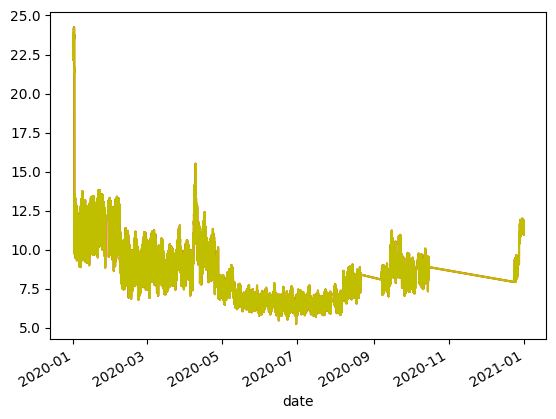

In [86]:
df_dewc['Dew_total'].plot(c='r')
#df_dewc['Dew_total1'].plot(c='b')
df_dewc['Deweathered'].plot(c='y')

<Axes: xlabel='date'>

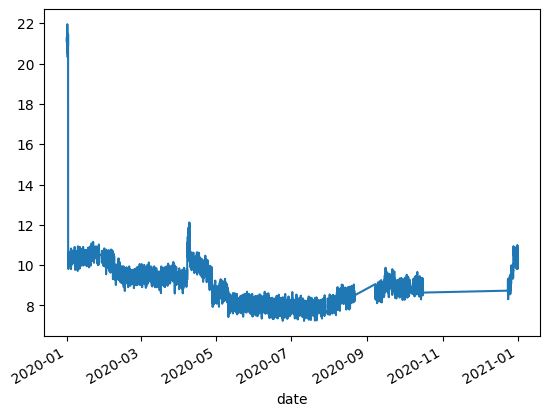

In [87]:
df_dewc['date_unix'].plot()

In [88]:
automlfi = pd.DataFrame(data={'feature_importances': automl.feature_importances_},
                            index=automl.feature_names_in_).sort_values('feature_importances', ascending=True)

In [89]:
df_deww = df1a[['date', 'value']].set_index('date').rename(columns={'value': 'Observed'})

In [90]:
MET_list = ['all'] + [item for item in automlfi.index if item not in ['hour', 'weekday', 'day_julian', 'date_unix']]

In [91]:
MET_list

['all', 'rh2m', 'ssrd', 'tcc', 'tp', 't2m', 'v10', 'sp', 'd2m', 'u10', 'blh']

In [92]:
var_names =['rh2m', 'ssrd', 'tcc', 'tp', 't2m', 'v10', 'sp', 'd2m', 'u10', 'blh']
feature_names=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m','date_unix', 'day_julian', 'weekday', 'hour']
for var_to_exclude in MET_list:
    var_names = list(set(var_names) - set([var_to_exclude]))
    df_dew_temp = normalise(automl, df1a, feature_names=feature_names, variables=var_names, n_samples=300, n_cores=-1, seed=7654321)
    df_deww[var_to_exclude] = df_dew_temp['Normalised']

2024-06-20 18:21:37 : Sampling and predicting 300 times...
2024-06-20 18:21:40 : Sampling and predicting 300 times...
2024-06-20 18:21:42 : Sampling and predicting 300 times...
2024-06-20 18:21:45 : Sampling and predicting 300 times...
2024-06-20 18:21:47 : Sampling and predicting 300 times...
2024-06-20 18:21:50 : Sampling and predicting 300 times...
2024-06-20 18:21:52 : Sampling and predicting 300 times...
2024-06-20 18:21:55 : Sampling and predicting 300 times...
2024-06-20 18:21:57 : Sampling and predicting 300 times...
2024-06-20 18:21:59 : Sampling and predicting 300 times...
2024-06-20 18:22:01 : Sampling and predicting 300 times...


<Axes: xlabel='date'>

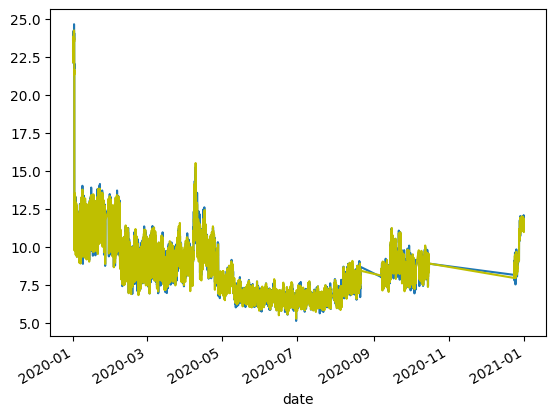

In [96]:
df_deww['all'].plot()
df_dewc['Deweathered'].plot(c='y')

In [100]:
df_dewwc = df_deww.copy()
MET_list = ['rh2m', 'ssrd', 'tcc', 'tp', 't2m', 'v10', 'sp', 'd2m', 'u10', 'blh']

for i, param in enumerate(MET_list):
    if i > 0:
        df_dewwc[param] = df_deww[param] - df_deww[MET_list[i - 1]]
    else:
        df_dewwc[param] = df_deww[param] - df_deww['all']

df_dewwc['met_noise'] = df_deww['Observed'] - df_deww['blh']


In [101]:
df_dewwc.head()

,Observed,all,rh2m,ssrd,tcc,tp,t2m,v10,sp,d2m,u10,blh,met_noise
date,,,,,,,,,,,,,
2020-01-01 00:00:00,58.1,23.656015,0.214352,-0.886303,1.262739,-0.627447,1.463223,1.392202,0.411390,0.638956,12.946438,8.227825,9.400610
2020-01-01 01:00:00,43.2,24.041840,-0.430141,-0.671677,0.973026,-0.431784,1.137529,1.429447,0.667141,1.048649,10.658249,5.418430,-0.640710
2020-01-01 02:00:00,43.0,22.934675,-0.824768,-0.751949,1.080313,-0.516132,1.468185,1.619930,0.744158,0.921062,11.689520,3.270473,1.364532
2020-01-01 03:00:00,42.8,22.623621,-1.333876,-0.638924,0.848963,-0.333582,1.225166,1.695885,0.847919,1.001566,11.562761,3.306919,1.993581
2020-01-01 04:00:00,36.8,22.385853,-1.207144,-0.411726,0.732025,-0.215109,1.103270,1.580677,0.705496,1.025215,7.770060,2.148548,1.182835


In [104]:
df_dewwc['MET_sum']=np.sum(df_dewwc.loc[:,'rh2m':'met_noise'],axis=1)
df_dewwc['MET']=df_dewwc['Observed']-df_dewwc['all']

<Axes: xlabel='date'>

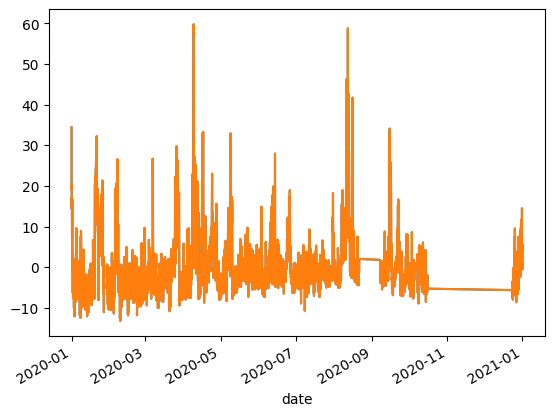

In [105]:
df_dewwc['MET_sum'].plot()
df_dewwc['MET'].plot()

In [117]:
def met_decom(df, value, feature_names, split_method='random', time_budget=60, metric='r2',
              estimator_list=["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"], task='regression',
              n_samples=300, fraction=0.75, seed=7654321, importance_ascending=False, n_cores=-1):
    """
    Decomposes a time series into different components using machine learning models with feature importance ranking.

    This function prepares the data, trains a machine learning model using AutoML, and decomposes the time series data
    into various components. The decomposition is based on the feature importance ranking and their contributions to the
    target variable. It returns the decomposed data and model statistics.

    Parameters:
        df (pd.DataFrame): Input dataframe containing the time series data.
        value (str): Column name of the target variable.
        feature_names (list of str): List of feature column names.
        split_method (str, optional): Method to split the data ('random' or other methods). Default is 'random'.
        time_budget (int, optional): Time budget for the AutoML training in seconds. Default is 60.
        metric (str, optional): Metric to evaluate the model ('r2', 'mae', etc.). Default is 'r2'.
        estimator_list (list of str, optional): List of estimators to be used in AutoML. Default is ["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"].
        task (str, optional): Task type ('regression' or 'classification'). Default is 'regression'.
        n_samples (int, optional): Number of samples for normalization. Default is 300.
        fraction (float, optional): Fraction of data to be used for training. Default is 0.75.
        seed (int, optional): Random seed for reproducibility. Default is 7654321.
        importance_ascending (bool, optional): Sort order for feature importances. Default is False.
        n_cores (int, optional): Number of cores to be used (-1 for all available cores). Default is -1.

    Returns:
        df_dewwc (pd.DataFrame): Dataframe with decomposed components.
        mod_stats (pd.DataFrame): Dataframe with model statistics.

    Example:
        >>> df = pd.read_csv('timeseries_data.csv')
        >>> value = 'target'
        >>> feature_names = ['feature1', 'feature2', 'feature3']
        >>> df_dewwc, mod_stats = met_decom(df, value, feature_names)
    """

    # Prepare the data for modeling
    df = prepare_data(df, value=value, feature_names=feature_names, split_method=split_method, fraction=fraction, seed=seed)

    # Train the model using AutoML
    automl = train_model(df, value='value', variables=feature_names, time_budget=time_budget, metric=metric, task=task, seed=seed)

    # Gather model statistics for testing, training, and all data
    mod_stats = pd.concat([
        modStats(df, automl, set='testing'),
        modStats(df, automl, set='training'),
        modStats(df.assign(set="all"), automl, set='all')
    ])

    # Determine feature importances and sort them

    automlfi = pd.DataFrame(data={'feature_importances': automl.feature_importances_},
                            index=automl.feature_names_in_).sort_values('feature_importances', ascending=importance_ascending)

    # Initialize the dataframe for decomposed components
    df_deww = df[['date', 'value']].set_index('date').rename(columns={'value': 'Observed'})
    MET_list = ['Deweathered'] + [item for item in automlfi.index if item not in ['hour', 'weekday', 'day_julian', 'date_unix']]
    var_names = [item for item in automlfi.index if item not in ['hour', 'weekday', 'day_julian', 'date_unix']]

    # Decompose the time series by excluding different features based on their importance
    for var_to_exclude in MET_list:
        var_names = list(set(var_names) - set([var_to_exclude]))
        df_dew_temp = normalise(automl, df, feature_names=feature_names, variables=var_names, n_samples=n_samples, n_cores=n_cores, seed=seed)
        df_deww[var_to_exclude] = df_dew_temp['Normalised']

    # Adjust the decomposed components to create weather-independent values
    df_dewwc = df_deww.copy()
    for i, param in enumerate([item for item in automlfi.index if item not in ['hour', 'weekday', 'day_julian', 'date_unix']]):
        if i > 0:
            df_dewwc[param] = df_deww[param] - df_deww[MET_list[i - 1]]
        else:
            df_dewwc[param] = df_deww[param] - df_deww['Deweathered']

    df_dewwc['met_noise'] = df_deww['Observed'] - df_deww[MET_list[-1]]

    return df_dewwc, mod_stats

In [118]:
df_dewc, mod_stats=met_decom(df1, value='PM2.5',feature_names=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m','date_unix', 'day_julian', 'weekday',
       'hour'], n_samples=300,fraction=0.75, seed=7654321, n_cores=-1)

2024-06-20 20:21:04 : Sampling and predicting 300 times...
2024-06-20 20:21:07 : Sampling and predicting 300 times...
2024-06-20 20:21:09 : Sampling and predicting 300 times...
2024-06-20 20:21:12 : Sampling and predicting 300 times...
2024-06-20 20:21:14 : Sampling and predicting 300 times...
2024-06-20 20:21:16 : Sampling and predicting 300 times...
2024-06-20 20:21:19 : Sampling and predicting 300 times...
2024-06-20 20:21:21 : Sampling and predicting 300 times...
2024-06-20 20:21:23 : Sampling and predicting 300 times...
2024-06-20 20:21:25 : Sampling and predicting 300 times...
2024-06-20 20:21:27 : Sampling and predicting 300 times...


In [59]:
df_dewwc['MET_total']=np.sum(df_dewwc.loc[:,'rh2m':'blh'],axis=1)

In [61]:
df_dewc['MET']=df_dewc['Observed']-df_dewc['Deweathered']

<Axes: xlabel='date'>

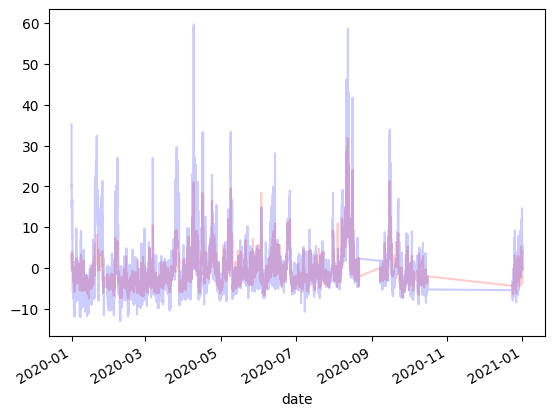

In [65]:
df_dewwc['MET_total'].plot(alpha=0.2,c='r')
df_dewc['MET'].plot(alpha=0.2,c='b')

In [70]:
df_dewwc['MET_total1']=df_dewwc['MET_total']-df_dewc['ts_residue']

<Axes: xlabel='date'>

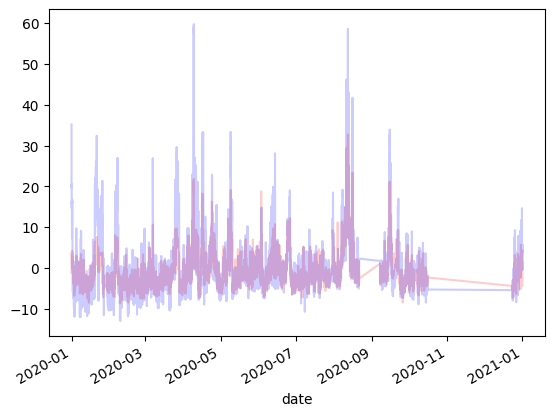

In [71]:
df_dewwc['MET_total1'].plot(alpha=0.2,c='r')
df_dewc['MET'].plot(alpha=0.2,c='b')

<Axes: xlabel='date'>

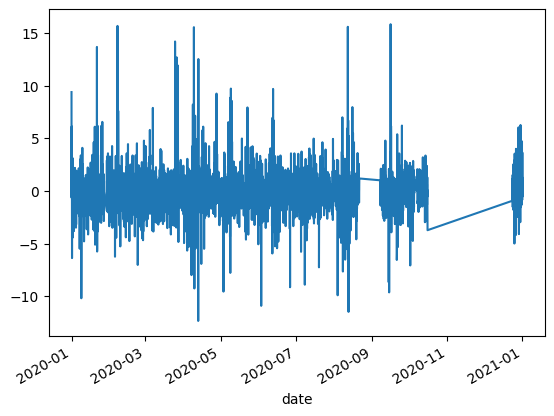

In [116]:
df_dewc['met_noise'].plot()

<Axes: xlabel='date'>

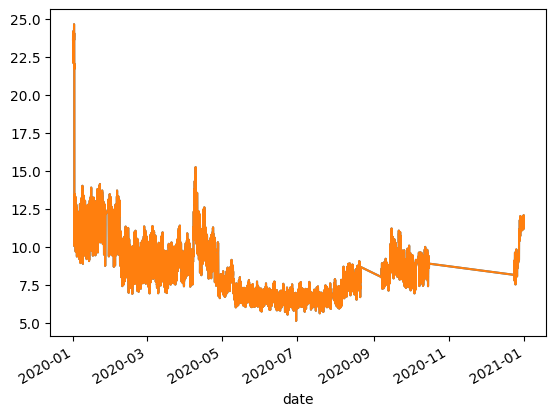

In [115]:
df_deww['all'].plot()
df_dewc['all'].plot()

In [121]:
def emi_decom(df, value, feature_names, split_method='random', time_budget=60, metric='r2',
             estimator_list=["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"], task='regression',
             n_samples=300, fraction=0.75, seed=7654321, n_cores=-1):
    """
    Decomposes a time series into different components using machine learning models.

    This function prepares the data, trains a machine learning model using AutoML, and decomposes
    the time series data into various components. The decomposition is based on the contribution
    of different features to the target variable. It returns the decomposed data and model statistics.

    Parameters:
        df (pd.DataFrame): Input dataframe containing the time series data.
        value (str): Column name of the target variable.
        feature_names (list of str): List of feature column names.
        split_method (str, optional): Method to split the data ('random' or other methods). Default is 'random'.
        time_budget (int, optional): Time budget for the AutoML training in seconds. Default is 60.
        metric (str, optional): Metric to evaluate the model ('r2', 'mae', etc.). Default is 'r2'.
        estimator_list (list of str, optional): List of estimators to be used in AutoML. Default is ["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"].
        task (str, optional): Task type ('regression' or 'classification'). Default is 'regression'.
        n_samples (int, optional): Number of samples for normalization. Default is 300.
        fraction (float, optional): Fraction of data to be used for training. Default is 0.75.
        seed (int, optional): Random seed for reproducibility. Default is 7654321.
        n_cores (int, optional): Number of cores to be used (-1 for all available cores). Default is -1.

    Returns:
        df_dewc (pd.DataFrame): Dataframe with decomposed components.
        mod_stats (pd.DataFrame): Dataframe with model statistics.

    Example:
        >>> df = pd.read_csv('timeseries_data.csv')
        >>> value = 'target'
        >>> feature_names = ['feature1', 'feature2', 'feature3']
        >>> df_dewc, mod_stats = ts_decom(df, value, feature_names)
    """

    # Prepare the data for modeling
    df = prepare_data(df, value=value, feature_names=feature_names, split_method=split_method, fraction=fraction, seed=seed)

    # Train the model using AutoML
    automl = train_model(df, value='value', variables=feature_names, time_budget=time_budget, metric=metric, task=task, seed=seed)

    # Gather model statistics for testing, training, and all data
    mod_stats = pd.concat([modStats(df, automl, set='testing'),
                           modStats(df, automl, set='training'),
                           modStats(df.assign(set="all"), automl, set='all')])

    # Initialize the dataframe for decomposed components
    var_names = feature_names
    df_dew = df[['date', 'value']].set_index('date').rename(columns={'value': 'Observed'})

    # Decompose the time series by excluding different features
    for var_to_exclude in ['base', 'date_unix', 'day_julian', 'weekday', 'hour']:
        var_names = list(set(var_names) - set([var_to_exclude]))
        df_dew_temp = normalise(automl, df, feature_names=feature_names, variables=var_names,
                                n_samples=n_samples, n_cores=n_cores, seed=seed)

        df_dew[var_to_exclude] = df_dew_temp['Normalised']

    # Adjust the decomposed components to create deweathered values
    df_dewc = df_dew.copy()
    df_dewc['hour'] = df_dew['hour'] - df_dew['weekday']
    df_dewc['weekday'] = df_dew['weekday'] - df_dew['day_julian']
    df_dewc['day_julian'] = df_dew['day_julian'] - df_dew['date_unix']
    df_dewc['date_unix'] = df_dew['date_unix'] - df_dew['base'] + df_dew['base'].mean()
    df_dewc['emi_noise'] =  df_dew['base']- df_dew['base'].mean()
    df_dewc['Deweathered'] = df_dew['hour']

    return df_dewc, mod_stats

In [132]:
df_dewc1, mod_stats=emi_decom(df1, value='PM2.5',feature_names=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m','date_unix', 'day_julian', 'weekday',
       'hour'], split_method = 'random',time_budget=60,
                  n_samples=300,fraction=0.75)

2024-06-20 20:35:54 : Resampling ['hour', 'tp', 'rh2m', 'v10', 'sp', 'u10', 'd2m', 'blh', 'ssrd', 'day_julian', 'weekday', 'tcc', 't2m', 'date_unix']  and predicting 300 times...
2024-06-20 20:35:57 : Resampling ['hour', 'tp', 'rh2m', 'v10', 'sp', 'u10', 'd2m', 'blh', 'ssrd', 'day_julian', 'weekday', 'tcc', 't2m']  and predicting 300 times...
2024-06-20 20:36:00 : Resampling ['hour', 'tp', 'rh2m', 'v10', 'sp', 'u10', 'd2m', 'blh', 'ssrd', 'weekday', 'tcc', 't2m']  and predicting 300 times...
2024-06-20 20:36:03 : Resampling ['hour', 'tp', 'rh2m', 'v10', 'sp', 'u10', 'd2m', 'blh', 'ssrd', 'tcc', 't2m']  and predicting 300 times...
2024-06-20 20:36:06 : Resampling ['tp', 'rh2m', 'v10', 'sp', 'u10', 'd2m', 'blh', 'ssrd', 'tcc', 't2m']  and predicting 300 times...


In [133]:
df_dewc1

,Observed,base,date_unix,day_julian,weekday,hour,emi_noise,Deweathered
date,,,,,,,,
2020-01-01 00:00:00,58.1,9.551792,21.300529,1.214783,1.290417,-0.553169,0.403455,23.656015
2020-01-01 01:00:00,43.2,9.389310,21.584976,1.646288,1.155987,-0.586384,0.240973,24.041840
2020-01-01 02:00:00,43.0,9.132077,20.942314,1.440413,1.023249,-0.455040,-0.016260,22.934675
2020-01-01 03:00:00,42.8,9.278408,21.108650,1.246431,0.935360,-0.796890,0.130071,22.623621
2020-01-01 04:00:00,36.8,8.912662,21.007887,1.603237,0.716171,-0.705767,-0.235676,22.385853
...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,11.7,8.806517,10.525983,1.111504,-0.143186,0.037580,-0.341821,11.190061
2020-12-31 20:00:00,11.0,8.629436,10.923817,1.076178,0.051250,0.020875,-0.518901,11.553219
2020-12-31 21:00:00,15.3,8.297555,10.931462,0.906650,0.305939,-0.081566,-0.850782,11.211702


In [125]:
str(feature_names)

"['u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m', 'date_unix', 'day_julian', 'weekday', 'hour']"

In [134]:
df_dewc, mod_stats=met_decom(df1, value='PM2.5',feature_names=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m','date_unix', 'day_julian', 'weekday',
       'hour'], n_samples=300,fraction=0.75, seed=7654321, n_cores=-1)

2024-06-20 20:37:09 : Resampling ['tp', 'rh2m', 'v10', 'sp', 'u10', 'blh', 'd2m', 'ssrd', 'tcc', 't2m']  and predicting 300 times...
2024-06-20 20:37:12 : Resampling ['tp', 'rh2m', 'v10', 'sp', 'u10', 'd2m', 'ssrd', 'tcc', 't2m']  and predicting 300 times...
2024-06-20 20:37:15 : Resampling ['tp', 'rh2m', 'v10', 'sp', 'd2m', 'ssrd', 'tcc', 't2m']  and predicting 300 times...
2024-06-20 20:37:17 : Resampling ['tp', 'rh2m', 'v10', 'sp', 'ssrd', 'tcc', 't2m']  and predicting 300 times...
2024-06-20 20:37:20 : Resampling ['tp', 'rh2m', 'v10', 'ssrd', 'tcc', 't2m']  and predicting 300 times...
2024-06-20 20:37:22 : Resampling ['tp', 'rh2m', 'ssrd', 'tcc', 't2m']  and predicting 300 times...
2024-06-20 20:37:24 : Resampling ['tcc', 'tp', 'ssrd', 'rh2m']  and predicting 300 times...
2024-06-20 20:37:26 : Resampling ['tcc', 'rh2m', 'ssrd']  and predicting 300 times...
2024-06-20 20:37:29 : Resampling ['rh2m', 'ssrd']  and predicting 300 times...
2024-06-20 20:37:31 : Resampling ['rh2m']  and p

In [135]:
df_dewc

,Observed,Deweathered,blh,u10,d2m,sp,v10,t2m,tp,tcc,ssrd,rh2m,met_noise
date,,,,,,,,,,,,,
2020-01-01 00:00:00,58.1,23.656015,2.196995,15.002958,13.243826,2.636894,6.185566,5.294746,2.601963,1.763260,0.512222,0.345516,9.400610
2020-01-01 01:00:00,43.2,24.041840,0.577974,9.695534,9.914225,3.014687,5.779575,5.283745,2.614799,2.098881,1.374718,-0.293976,-0.640710
2020-01-01 02:00:00,43.0,22.934675,-0.301016,6.221579,8.145325,3.361320,4.580292,5.069073,3.247158,2.712685,2.850918,1.336136,1.364532
2020-01-01 03:00:00,42.8,22.623621,-0.935078,5.857092,9.254402,3.418297,3.106153,4.581654,3.114723,2.635635,3.385986,1.690121,1.993581
2020-01-01 04:00:00,36.8,22.385853,-0.670269,1.735344,5.226881,3.802227,2.431696,3.862022,2.905994,1.883930,2.823662,1.947788,1.182835
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,11.7,11.190061,-0.362274,-0.284766,0.173565,0.325139,0.368815,0.863099,0.769813,0.119658,0.077868,-0.240358,-0.272833
2020-12-31 20:00:00,11.0,11.553219,-0.435986,-0.338394,0.079015,0.209784,0.329418,0.898524,0.844995,-0.523614,-0.584370,-0.227578,-0.571940
2020-12-31 21:00:00,15.3,11.211702,-0.326160,-0.220965,0.192039,0.341187,0.365214,0.889015,0.822505,-0.522148,-0.467716,-0.051594,3.652803


In [136]:
df_dewc1

,Observed,base,date_unix,day_julian,weekday,hour,emi_noise,Deweathered
date,,,,,,,,
2020-01-01 00:00:00,58.1,9.551792,21.300529,1.214783,1.290417,-0.553169,0.403455,23.656015
2020-01-01 01:00:00,43.2,9.389310,21.584976,1.646288,1.155987,-0.586384,0.240973,24.041840
2020-01-01 02:00:00,43.0,9.132077,20.942314,1.440413,1.023249,-0.455040,-0.016260,22.934675
2020-01-01 03:00:00,42.8,9.278408,21.108650,1.246431,0.935360,-0.796890,0.130071,22.623621
2020-01-01 04:00:00,36.8,8.912662,21.007887,1.603237,0.716171,-0.705767,-0.235676,22.385853
...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,11.7,8.806517,10.525983,1.111504,-0.143186,0.037580,-0.341821,11.190061
2020-12-31 20:00:00,11.0,8.629436,10.923817,1.076178,0.051250,0.020875,-0.518901,11.553219
2020-12-31 21:00:00,15.3,8.297555,10.931462,0.906650,0.305939,-0.081566,-0.850782,11.211702
